# Feature Selection

### The objective of this assignment is to assess the impact of feature selection on training and test datasets. We use four 3 feature selection methods and evaluate the methods based on the results obtained and also identigying the subset of good features.

### The two datasets accompany this assignment, SPECT_train.csv and SPECT_test.csv. GradientBoostingClassifier is the Classifier used for this activity and the libraries used are imported below.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt


### The data is imported and segregated into y_train, X_train, y_test and X_test.

In [3]:
spectf_train = pd.read_csv('SPECTF_train.csv')
spectf_test = pd.read_csv('SPECTF_test.csv')

y_train = spectf_train.pop('DIAGNOSIS').values
X_train = spectf_train.values

y_test = spectf_test.pop('DIAGNOSIS').values
X_test = spectf_test.values

### Creating a Gradient Boosting Classifier model with random state 3. This model will be used throughout the activity.

In [4]:
model = GradientBoostingClassifier(random_state=3)

### In the first stage we prepare a baseline by running through the model using all the features.

In [5]:
accuracy_all_features_cv = cross_val_score(model, X_train, y_train, cv=4).mean()*100
print("Accuracy on taining data using Cross Validation : %.2f%% " % (accuracy_all_features_cv))


model.fit(X_train, y_train)
y_results_ho = model.predict(X_test)
accuracy_all_features_ho = accuracy_score(y_test, y_results_ho)*100
print("Accuracy using hold out (train and test) : %.2f%% " % (accuracy_all_features_ho))

Accuracy on taining data using Cross Validation : 78.75% 
Accuracy using hold out (train and test) : 71.12% 


### The accuracy between train and test sets differ approx. by 9%.

# Information Gain feature subset selection strategy

### Information Gain measures how much information a feature gives us about the class. We calculate the information gain for all the features using mutual_info_classif() method from sklearn.feature_selection. 

In [6]:
i_scores = mutual_info_classif(X_train, y_train)

mi = dict()
for i,j in zip(spectf_train.columns,i_scores):
    mi[i]=j
 
df = pd.DataFrame.from_dict(mi,orient='index',columns=['I-Gain'])
df.sort_values(by=['I-Gain'],ascending=False,inplace=True)

df.head(7)

,I-Gain
F20S,0.213393
F15S,0.198758
F21R,0.176296
F13R,0.148156
F13S,0.140523
F2S,0.136281
F16R,0.128529


### The Information gain for all the features is calculated, sorted in descending order and put into a dataframe. Further, we calculate the accuracy for using SelectKBest() method and add it to the dataframe.


In [7]:

acc_scores = []
for kk in range(1, X_train.shape[1]+1):
    FS_trans = SelectKBest(mutual_info_classif, k=kk).fit(X_train, y_train)
    X_tR_new = FS_trans.transform(X_train)
    X_tS_new = FS_trans.transform(X_test)
    acc = cross_val_score(model, X_tR_new, y_train, cv=4).mean()
    acc_scores.append(acc)

df['Accuracy'] = acc_scores
accuracy_IG_CV = df['Accuracy'].max() * 100

print("Accuracy using CV after feature selection using I-Gain : %.2f%% " % (accuracy_IG_CV))
df.head(10)

Accuracy using CV after feature selection using I-Gain : 80.00% 


,I-Gain,Accuracy
F20S,0.213393,0.7250
F15S,0.198758,0.7125
F21R,0.176296,0.7500
F13R,0.148156,0.7250
F13S,0.140523,0.7375
F2S,0.136281,0.7000
F16R,0.128529,0.7125
F5S,0.121393,0.7625
F22S,0.115321,0.7750
F11S,0.104361,0.7500


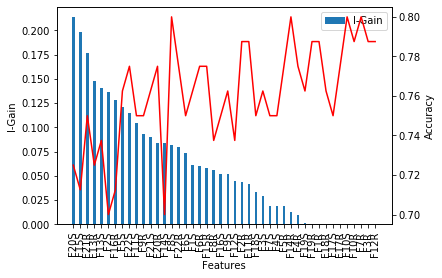

In [8]:
%matplotlib inline

n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=.35)
ax2.plot(df.index, df["Accuracy"], color='red', label='Accuracy')
ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax2.set_ylabel('Accuracy')
ax.legend()
plt.show()

### Above is the graph of where features are plotted in the decreasing order of the I-Gain values and also where Accuracy is ploted against I-Gain values. We can see that the accuracy of the graph starts dipping after F20R which is the 16th feature and hence we will consider top 16 features with the highest IGain values to prepare the subset of features. 

### Please note that we get different I-Gain values on different runs and so the graph might show some discrepancy.

In [9]:
selected_features = df.index.values[0:15]

X_tR_new = spectf_train[selected_features].values
X_tS_new = spectf_test[selected_features].values

model.fit(X_tR_new, y_train)

y_pred = model.predict(X_tS_new)
accuracy_IG_HO = accuracy_score(y_test, y_pred)*100

print("Accuracy using hold out after feature selection using I-Gain : %.2f%% " % (accuracy_IG_HO))

Accuracy using hold out after feature selection using I-Gain : 73.26% 


### Comparing the accuracies of test and train we can see a difference of approx. 12%.
### The drawback of Information gain is that it values the variables with the large numbe of values. It does not consider the model using which the predictions are to be made and also the inter feature dependencies.

### Further, the results were slightly inconsistent due the random initialization during the I-Gain calulcation. The was noticable difference in the I-Gain values in different runs; so we can say that this method of finding the subsets cannot be relied upon. 

# Wrapper-based Forward Sequential Search

### The wrapper methods overcome the disadvantages of Information gain. They consider the learning algorithm and also the inter feature dependencies. 

### In Forward Sequential Search, we start with empty set of features. Then we keep on adding features until there is no further increase in the accuracy. Using the SFS() method of mlxtend.feature_selection we fit a sequential forward selection model and runnin it for all the features in the first run.

In [10]:

sfs_forward = SFS(model, 
                  k_features=44, 
                  forward=True, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=4, n_jobs = -1)

sfs_forward = sfs_forward.fit(X_train, y_train, custom_feature_names=spectf_train.columns)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    2.4s finished
Features: 1/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    2.3s finished
Features: 2/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    2.4s finished
Features: 3/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    2.3s finished
Features: 4/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished
Features: 5/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.2s finished
Features: 6/44[Parallel(n_jobs=-1)]: Using backe

In [11]:
accuracy_cv_forward = pd.DataFrame.from_dict(sfs_forward.get_metric_dict()).T['avg_score'].max()*100
print("Maximum accuracy using 4 fold CV using SFS is : %.2f%% " % (accuracy_cv_forward))

Maximum accuracy using 4 fold CV using SFS is : 88.75% 


### We now have calculated the matrics of features and their respective accuracies. Below is the graph for the same.

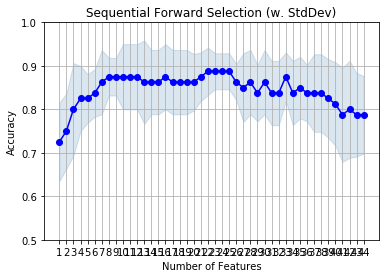

In [12]:
fig = plot_sfs(sfs_forward.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

### From the graph we can see that the accuracy dips after 23rd feature and so we will consider 23 best features as the best subset to fit our model as done below.

In [13]:
sfs_forward = SFS(model, 
                  k_features=23, 
                  forward=True, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv = 4,
                  n_jobs = -1)

sfs_forward = sfs_forward.fit(X_train, y_train, custom_feature_names=spectf_train.columns)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    2.4s finished
Features: 1/23[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    2.4s finished
Features: 2/23[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    2.6s finished
Features: 3/23[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    3.0s finished
Features: 4/23[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished
Features: 5/23[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.3s finished
Features: 6/23[Parallel(n_jobs=-1)]: Using backe

### Now that we have found 23 best features for this model, we transform both the train and test dataset using these features and fit the model.

In [14]:
X_train_sfs = sfs_forward.transform(X_train)
X_test_sfs = sfs_forward.transform(X_test)

model.fit(X_train_sfs, y_train)
y_pred = model.predict(X_test_sfs)

# Computing the accuracy of the prediction
accuracy_ho_forward = float((y_test == y_pred).sum()) / y_pred.shape[0]* 100
print("Accuracy using hold out after feature selection using SFS : %.2f%% " % (accuracy_ho_forward))

Accuracy using hold out after feature selection using SFS : 69.52% 


### The accuracy is calculated as above and is approx 14% lesser than that using CV.

### One of the important drawbacks of SFS is that it is unable to remove features that become obsolete after the addition of other features.

# Wrapper-based Backward Sequential Search

### In Backward Sequential Search, we start with set of all the features. Then we keep on removing the least important features until there is no further increase in the accuracy.

In [15]:
sfs_backward = SFS(model, 
                  k_features=1, 
                  forward=False, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=4, n_jobs = -1)

sfs_backward = sfs_backward.fit(X_train, y_train, custom_feature_names = spectf_train.columns)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    3.0s finished
Features: 43/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    3.0s finished
Features: 42/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    3.4s finished
Features: 41/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    3.7s finished
Features: 40/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished
Features: 39/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.8s finished
Features: 38/1[Parallel(n_jobs=-1)]: Using backe

In [16]:
accuracy_cv_backward = pd.DataFrame.from_dict(sfs_backward.get_metric_dict()).T['avg_score'].max()*100
print("Maximum accuracy using 4 fold CV using SFS is : %.2f%% " % (accuracy_cv_backward))

Maximum accuracy using 4 fold CV using SFS is : 90.00% 


### We now have calculated the matrics of features and their respective accuracies. Below is the graph for the same.

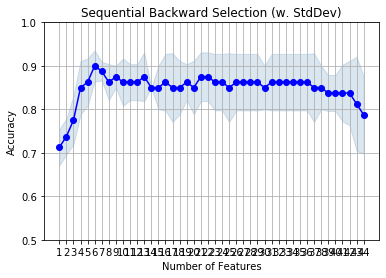

In [17]:
fig1 = plot_sfs(sfs_backward.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

### From the graph we can see that the accuracy dips after removal of 21 features in the list and so we will consider best 23 features as the best subset to fit our model.

In [18]:
sfs_backward = SFS(model, 
                  k_features=13, 
                  forward=False, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=4, n_jobs = -1)

sfs_backward = sfs_backward.fit(X_train, y_train, custom_feature_names = spectf_train.columns)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    2.9s finished
Features: 43/13[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    2.8s finished
Features: 42/13[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    2.9s finished
Features: 41/13[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    2.8s finished
Features: 40/13[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.0s finished
Features: 39/13[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.7s finished
Features: 38/13[Parallel(n_jobs=-1)]: Using

### Now that we have found 23 best features for this model, we transform both the train and test dataset using these features and fit the model.

In [19]:
X_train_sfs = sfs_backward.transform(X_train)
X_test_sfs = sfs_backward.transform(X_test)

model.fit(X_train_sfs, y_train)
y_pred = model.predict(X_test_sfs)

# Computing the accuracy of the prediction
accuracy_ho_backward = float((y_test == y_pred).sum()) / y_pred.shape[0] * 100
print("Accuracy using hold out after feature selection using SBS : %.2f%% " % (accuracy_ho_backward))

Accuracy using hold out after feature selection using SBS : 70.59% 


###  The accuracy is calculated as above and is approx 36% lesser than that using CV.


### Similar to the drawback of SFS, one of the main drawbacks of SBS is that it is unable to add features that become obsolete after the addition of other features.

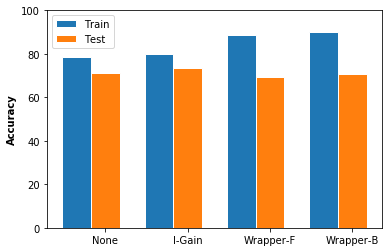

In [20]:
# PLOT
import numpy as np

labels = ['All', 'I-Gain', 'FSFS', 'BSFS']
cv = [accuracy_all_features_cv, accuracy_IG_CV, accuracy_cv_forward, accuracy_cv_backward]
ho = [accuracy_all_features_ho, accuracy_IG_HO, accuracy_ho_forward, accuracy_ho_backward]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
r1 = np.arange(len(cv))
r2 = [x + width for x in r1]


# Make the plot
plt.bar(r1, cv, width=width, edgecolor='white', label='Train')
plt.bar(r2, ho, width=width, edgecolor='white', label='Test')

axes = plt.gca()
axes.set_ylim([0,100])

# Add xticks on the middle of the group bars
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + width for r in range(len(cv))], ['None', 'I-Gain', 'Wrapper-F', 'Wrapper-B'])
 
# Create legend & Show graphic
plt.legend()
plt.show()


#### Above is the graph to compare the feature selection method: I-Gain, SFS and SBS.

### To start with, it is noticable that there the accuracy on Test dataset is always greater than that of the Train dataset. The reason is very obvious as the test accuracy is calculated after performing a cross validation test and the test accuracy is calculated using a hold-out test; and since the dataset is very small, the model gets to see very less number of variables and so the hold-out test doesn't yeild a good accuracy.

### Begining with the wrapper methodologies, they do not do a very decent job in finding out the right subset of features in this case. Even though Sequential backward search scores the highest accuracy of 96.25% during the training phase it performs the worst when run on test data and achieves only around 60%. Similar is the case with Sequential Forward selection method which has prettry good accuracy on the trian but doesn't score well when run on the test data. 

### This could well be because of the overfitting; as in our case we are only taining the data with 80 variables. This sample is clearly insufficient and so the preformance goes down. Another reason that often happens with Sequential selection is that the feature subset works well on the training data but does not perform well not the unseen data. The fact we get different answers from forward and backward selection methods when we change the value of seed puts us into a thought of the unstability. Hence, this would be a selection method that should atleast not be used when we have a significantly large trainig dataset.



### On the other hand, I-Gain does a prettry decent job when comapred to other methods in selecting a good subser of features. Even though we achieve the highest accuracy on test data when we fit the model using all the features, test accuracy achieved by I-Gain is just 2% lesser than that of the latter. So, we can say that I-Gain is the best feature selection method that can be used on this particular dataset.